In [1]:
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

from mrf_cut import create_pairwise_mrf, graph_cut_mrf, segment_image, get_unary_log_odds
from bar_example import bar_generator, create_bar, add_gray_noise, add_flip_noise

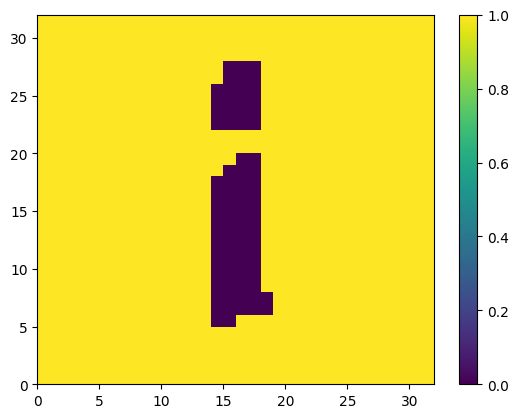

In [2]:
class VideoSegmenter:
    def __init__(self, p=0.2, b=1.0, beta=2.5, len_history=3):
        self.hyperams = {"p": p, "b": b, "beta": beta}
        self.input_history = deque(maxlen=len_history)
        self.output_history = deque(maxlen=len_history)
    
    def unary_potential(self, value, index):
        if len(self.output_history) == 0:
            return value, 1 - value
        prev_val = self.output_history[-1][index]
        p = self.hyperams["p"]
        bp = 0.2
        # return value * bp * (1 - p) + (prev_val * bp * p), (1 - value) * (1 - bp)
        return value * bp * (1 - p) + (prev_val * bp * p), (1 - value) * (1 - bp) * (1 - p) + (1 - prev_val) * (1 - bp) * (p)
        return value, (1 - prev_val) * p + (1 - p) * (1 - value)
    
    def pairwise_potential(self, val1, val2, *args):
        return self.hyperams["beta"]
        return (1 - abs(val1 - val2)) * self.hyperams["b"]

    def step(self, noisy):
        # create pairwise mrf
        image = segment_image(noisy, unary_potential_fnc=self.unary_potential, pairwise_potential_fnc=self.pairwise_potential)
        self.input_history.append(noisy)
        self.output_history.append(image)

        return image

segmenter = VideoSegmenter()
image = segmenter.step(add_flip_noise(create_bar()))
plt.pcolormesh(image)
plt.colorbar()

In [3]:
fig, axs = plt.subplots(1, 3)

bar_ref = create_bar()
noisy = add_flip_noise(bar_ref, 0.22)

segmenter = VideoSegmenter(p=0.3)

map_bar1 = segmenter.step(noisy)
map_bar2 = VideoSegmenter(beta=1.).step(noisy)
noisy_mesh = axs[0].pcolormesh(noisy, vmin=0, vmax=1)
map_mesh = axs[1].pcolormesh(map_bar1, vmin=0, vmax=1)
map_mesh2 = axs[2].pcolormesh(map_bar2, vmin=0, vmax=1)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    noisy = add_flip_noise(bar_ref, 0.22)
    map_bar1 = segmenter.step(noisy)
    map_bar2 = VideoSegmenter().step(noisy)
    
    noisy_mesh.set_array(noisy)
    map_bar1[map_bar1 * (1 - bar_ref) == 1] = 0.33
    map_bar1[(1 - map_bar1) * (bar_ref) == 1] = 0.67
    map_mesh.set_array(map_bar1)
    # map_mesh.set_array(map_bar1 - (map_bar1) * (1 - bar_ref)*0.25 - (1 - map_bar1) * (bar_ref)*0.5)
    map_mesh2.set_array(map_bar2*0.5 + bar_ref*0.5)
    return noisy_mesh, map_mesh, map_mesh2

ani = FuncAnimation(fig, update, frames=range(10), blit=False, interval=100)
HTML(ani.to_jshtml())

In [4]:
fig, axs = plt.subplots(1, 3)

bar_gen = bar_generator()
bar_ref = next(bar_gen)
noisy = add_flip_noise(bar_ref, 0.15)

segmenter = VideoSegmenter(p=0.2, beta=1.5)

map_bar1 = segmenter.step(noisy)
map_bar2 = VideoSegmenter(beta=2.).step(noisy)
noisy_mesh = axs[0].pcolormesh(noisy, vmin=0, vmax=1)
map_mesh = axs[1].pcolormesh(map_bar1, vmin=0, vmax=1)
map_mesh2 = axs[2].pcolormesh(map_bar2, vmin=0, vmax=1)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    bar_ref = next(bar_gen)
    noisy = add_flip_noise(bar_ref, 0.15)
    map_bar1 = segmenter.step(noisy)
    map_bar2 = VideoSegmenter().step(noisy)
    
    noisy_mesh.set_array(noisy)
    # map_bar1[map_bar1 * (1 - bar_ref) == 1] = 0.33
    # map_bar1[(1 - map_bar1) * (bar_ref) == 1] = 0.67
    map_mesh.set_array(map_bar1)
    # map_mesh.set_array(map_bar1 - (map_bar1) * (1 - bar_ref)*0.25 - (1 - map_bar1) * (bar_ref)*0.5)
    map_mesh2.set_array(map_bar2)#*0.5 + bar_ref*0.5)
    return noisy_mesh, map_mesh, map_mesh2

ani = FuncAnimation(fig, update, frames=range(10), blit=False, interval=100)
HTML(ani.to_jshtml())